In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14857110148305485176,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15643095071682443574
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16288704520264769133,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6258485669775641634
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [4]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [6]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
imgs, labels =next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

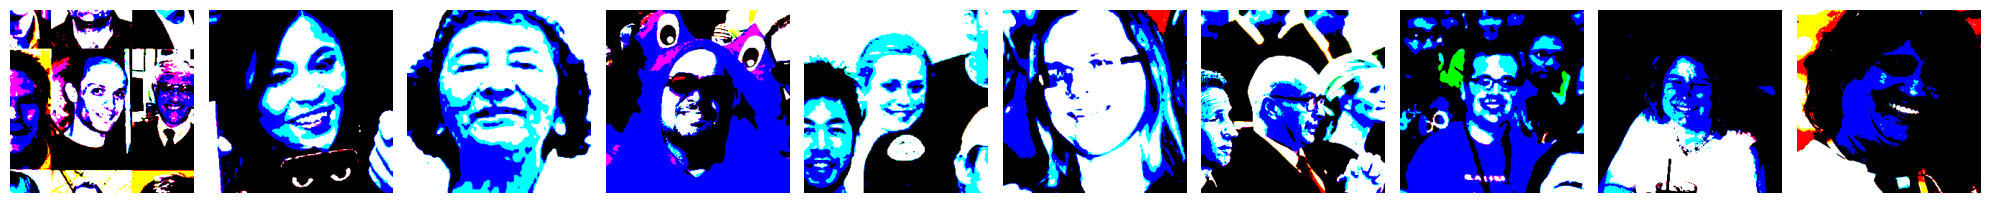

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [10]:
plotImages(imgs)
print(labels)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(256,256,3), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])



In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4910257570647638193,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14480297020995355259
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [17]:
model.compile(loss="binary_crossentropy",optimizer=SGD(learning_rate = 0.0001, momentum=0.9), metrics=['binary_accuracy'])

In [18]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=30,verbose=1)

Epoch 1/30
14001/14001 [==============================] - 1735s 123ms/step - loss: 5.5114 - binary_accuracy: 0.6836 - val_loss: 4.1649 - val_binary_accuracy: 0.7903
Epoch 2/30
14001/14001 [==============================] - 1740s 124ms/step - loss: 3.2027 - binary_accuracy: 0.8372 - val_loss: 2.4166 - val_binary_accuracy: 0.8842
Epoch 3/30
14001/14001 [==============================] - 1716s 123ms/step - loss: 1.8855 - binary_accuracy: 0.9094 - val_loss: 1.4589 - val_binary_accuracy: 0.9111
Epoch 4/30
14001/14001 [==============================] - 1614s 115ms/step - loss: 1.1564 - binary_accuracy: 0.9353 - val_loss: 0.9407 - val_binary_accuracy: 0.9174
Epoch 5/30
14001/14001 [==============================] - 1630s 116ms/step - loss: 0.7438 - binary_accuracy: 0.9466 - val_loss: 0.6362 - val_binary_accuracy: 0.9309
Epoch 6/30
14001/14001 [==============================] - 1675s 120ms/step - loss: 0.5071 - binary_accuracy: 0.9550 - val_loss: 0.4559 - val_binary_accuracy: 0.9435
Epoch 7/30

In [19]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

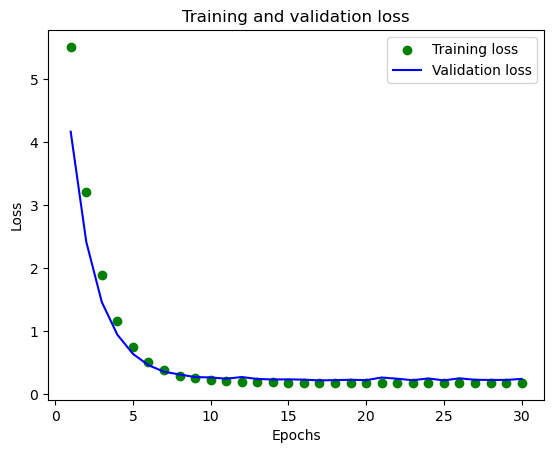

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, 31)

plt.scatter(epochs, loss_train, color='g', label='Training loss')
plt.plot(epochs, loss_val, color='b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



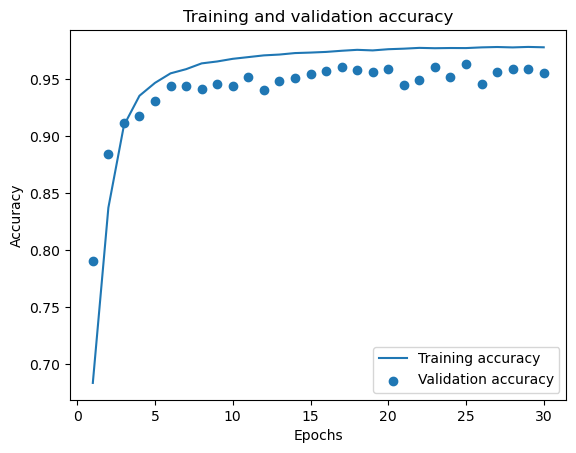

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(1, 31)

plt.plot(epochs, acc, label='Training accuracy')
plt.scatter(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [22]:
model.metrics_names

['loss', 'binary_accuracy']

In [23]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 112s 102ms/step


In [24]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [25]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [26]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [27]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[3221 2271]
 [3209 2204]]


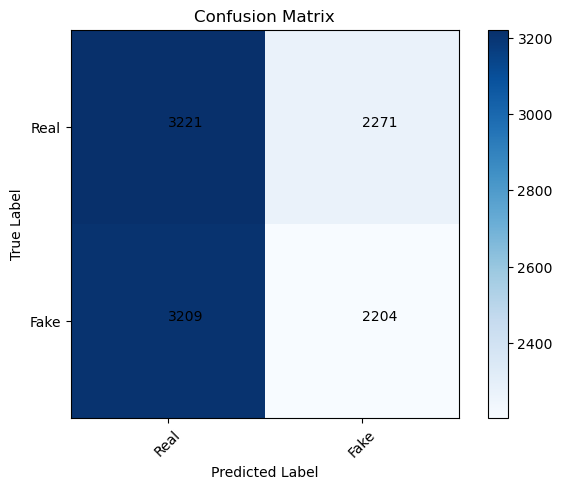

In [28]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [29]:
#import os.path
#if os.path.isfile('D:\DUmDum\deepfakes\DFmodel\DF.h5') is False:
    #model.save('D:\DUmDum\deepfakes\DFmodel\df2.h5')

In [30]:
from sklearn.metrics import accuracy_score, classification_report

In [31]:
#classification_report(test_batches.classes , np.round(predictions))

In [32]:
print(predictions.shape)

(10905, 2)


In [33]:
print(predictions)

[[1.0000000e+00 2.3124640e-16]
 [1.0000000e+00 1.3196710e-10]
 [1.0000000e+00 4.1745785e-09]
 ...
 [9.9999988e-01 9.9562854e-08]
 [9.9999988e-01 1.4725639e-07]
 [1.4716129e-01 8.5283875e-01]]


In [34]:
test_num_samples = test_batches.n
print("Number of samples in test set:", test_num_samples)


Number of samples in test set: 10905


In [35]:
y_true = test_batches.classes


In [36]:
from tensorflow.keras.utils import to_categorical


# Convert target variable to one-hot encoded format
test_labels_one_hot = to_categorical(test_batches.classes)

# Get predictions
#predictions = model.predict(test_batches, verbose=1)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_batches.classes, predicted_classes)
print(cm)


[[3221 2271]
 [3209 2204]]


In [37]:
from sklearn.metrics import classification_report

# Get predicted class labels
# Get predicted probabilities for test data
#y_pred = model.predict(test_batches)

# Convert probabilities to predicted class labels
y_pred_labels = np.argmax(predictions, axis=1)


# Get true class labels
true_classes = test_batches.classes

# Get class names
class_names = test_batches.class_indices.keys()

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print(report)


              precision    recall  f1-score   support

        Fake       0.50      0.59      0.54      5492
        Real       0.49      0.41      0.45      5413

    accuracy                           0.50     10905
   macro avg       0.50      0.50      0.49     10905
weighted avg       0.50      0.50      0.49     10905



In [43]:
import os.path
if os.path.isfile('D:/DUmDum/deepfakes/DFmodel/fin.h5') is False:
    model.save('D:/DUmDum/deepfakes/DFmodel/fin.h5')